# US East Coast Hindcast

Wave statistics analysis of hindcast data for the US East Coast.

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from oceanum.datamesh import Connector
from IPython.display import Image

from metocean_stats import plots, tables

import warnings
warnings.filterwarnings("ignore")

## Query timeseries from Datamesh

Use the Datamesh python library to search for the datasource and query the timeseries.

In [2]:
conn = Connector()

Using datamesh API version 0
You are using version 1.0.7 of oceanum_python which is the latest version available.


In [3]:
list(conn.get_catalog("useast swan parameters"))

[
         Oceanum Eastern United States 5km ECMWF wave nowcast parameters [oceanum_wave_ec_useast_grid_nowcast]
             Extent: (-77.5, 35.5, -63.0, 46.0)
             Timerange: 2025-03-24 12:00:00+00:00 to 2025-04-15 16:58:16+00:00
         ,
 
         Oceanum Eastern United States 5km ECMWF wave forecast parameters [oceanum_wave_ec_useast_grid]
             Extent: (-77.5, 35.5, -63.0, 46.0)
             Timerange: 2025-03-31 00:00:00+00:00 to 2025-03-31 12:30:20.657000+00:00
         ,
 
         Oceanum US East 5km wave hindcast parameters [oceanum_wave_useast_era5_grid]
             Extent: (-77.5, 35.5, -63.0, 46.0)
             Timerange: 1993-01-01 00:00:00+00:00 to 2024-12-01 00:00:00+00:00
         ]

In [4]:
def query_timeseries(datasource, lon, lat, t0=None, t1=None) -> xr.Dataset:
    """Query hindcast timeseries from Datamesh."""
    query = {
        "datasource": datasource,
        "variables": ["hs", "tps", "dpm"],
        "timefilter": {"type": "range", "times": [t0, t1]},
        "geofilter": {
            "type": "feature",
            "geom": {
                "type": "Feature",
                "geometry": {
                    "type": "Point",
                    "coordinates": [lon, lat],
                },
            },
        },
    }
    return conn.query(query).squeeze()


def query_snapshot(datasource, time) -> xr.Dataset:
    """Query hindcast timeseries from Datamesh."""
    query = {
        "datasource": datasource,
        "variables": ["hs"],
        "timefilter": {"type": "range", "times": [time, time]},
    }
    return conn.query(query).squeeze()

### Query timeseries at a point near the coast

In [5]:
lon = -73.5
lat = 40

In [6]:
ds = query_timeseries("oceanum_wave_useast_era5_grid", lon=lon, lat=lat)
ds

<xarray.Dataset> Size: 9MB
Dimensions:      (time: 279769)
Coordinates:
  * time         (time) datetime64[ns] 2MB 1993-01-01 ... 2024-12-01
    spatial_ref  int64 8B 0
    longitude    float64 8B -73.5
    latitude     float64 8B 40.0
Data variables:
    hs           (time) float64 2MB 0.3536 0.5041 0.5506 ... 1.336 1.383 1.409
    tps          (time) float64 2MB 2.183 2.844 2.914 2.938 ... 4.148 4.23 4.378
    dpm          (time) float64 2MB 22.4 19.25 15.48 303.4 ... 271.4 264.6 266.5
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    cycle:                   19960101T00
    model:                   41.31A
    project:                 Eastern United S
    run:                     usea
    xinterp_method:          linear
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           8952632

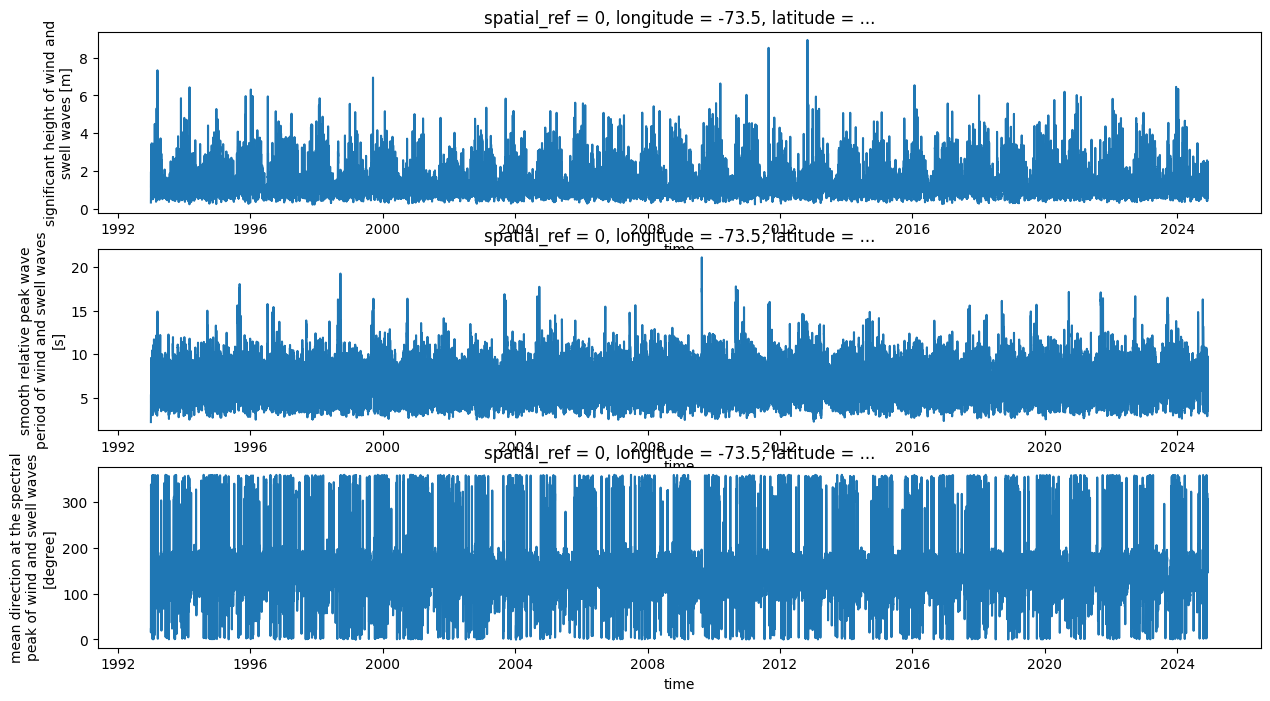

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(15, 8))

ds.hs.plot(ax=axs[0])
ds.tps.plot(ax=axs[1])
ds.dpm.plot(ax=axs[2])

### Query and plot a snapshot and select the point

In [8]:
snapshot = query_snapshot("oceanum_wave_useast_era5_grid", time="2024-01-01T00:00:00")
snapshot

<xarray.Dataset> Size: 248kB
Dimensions:    (latitude: 211, longitude: 291)
Coordinates:
  * latitude   (latitude) float32 844B 35.5 35.55 35.6 35.65 ... 45.9 45.95 46.0
  * longitude  (longitude) float32 1kB -77.5 -77.45 -77.4 ... -63.1 -63.05 -63.0
    time       datetime64[ns] 8B 2024-01-01
Data variables:
    hs         (latitude, longitude) float32 246kB nan nan nan ... nan nan nan
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    cycle:                   19960101T00
    model:                   41.31A
    project:                 Eastern United S
    run:                     usea
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           247620

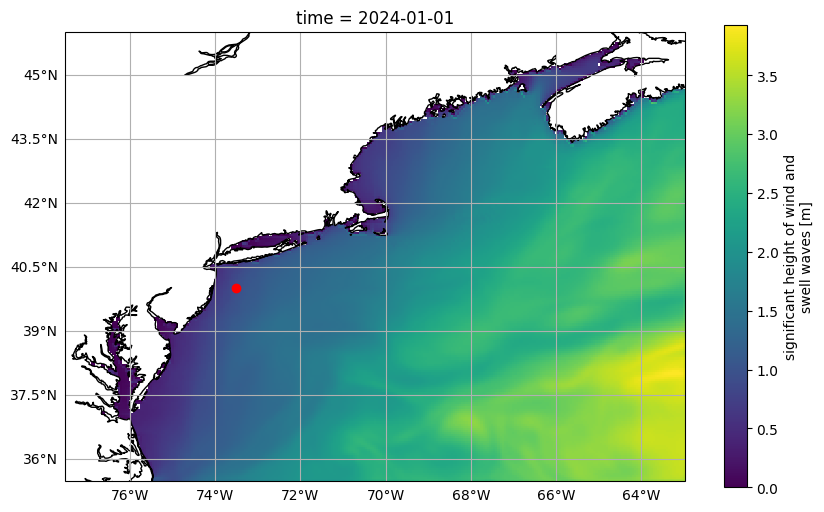

In [9]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

snapshot.hs.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="viridis")
ax.plot(-73.5, 40, "ro", transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=["left", "bottom"])

## Analyse hindcast

Use the [metocean-stats](https://github.com/MET-OM/metocean-stats) package to analyse
the hindcast data.

In [10]:
df = ds.to_pandas()
df.head()

,spatial_ref,hs,tps,dpm,longitude,latitude
time,,,,,,
1993-01-01 00:00:00,0,0.353600,2.182695,22.401871,-73.5,40.0
1993-01-01 01:00:00,0,0.504051,2.844071,19.245594,-73.5,40.0
1993-01-01 02:00:00,0,0.550638,2.913569,15.484455,-73.5,40.0
1993-01-01 03:00:00,0,0.614790,2.938008,303.354553,-73.5,40.0
1993-01-01 04:00:00,0,0.632355,3.083114,279.643982,-73.5,40.0


### Scatter diagram

In [11]:
tables.scatter_diagram(
    df,
    var1="tps",
    step_var1=2,
    var2="hs",
    step_var2=1,
    output_file="Hs_Tp_scatter.csv",
)

,0-1 | 36.36%,1-2 | 48.48%,2-3 | 11.33%,3-4 | 2.92%,4-5 | 0.71%,5-6 | 0.16%,6-7 | 0.03%,7-8 | 0.00%,8-9 | 0.00%
20.0-22.0 | 0.00%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
18.0-20.0 | 0.01%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
16.0-18.0 | 0.16%,0.01,0.06,0.06,0.03,0.01,0.00,0.00,0.0,0.0
14.0-16.0 | 0.44%,0.04,0.21,0.14,0.04,0.00,0.01,0.00,0.0,0.0
12.0-14.0 | 1.39%,0.30,0.65,0.25,0.11,0.04,0.01,0.01,0.0,0.0
10.0-12.0 | 10.09%,3.19,4.32,1.50,0.74,0.25,0.08,0.01,0.0,0.0
08.0-10.0 | 34.73%,14.92,14.39,3.82,1.17,0.37,0.07,0.00,0.0,0.0
06.0-08.0 | 30.54%,11.55,14.54,3.61,0.80,0.04,0.00,0.00,0.0,0.0
04.0-06.0 | 19.22%,3.85,13.39,1.95,0.03,0.00,0.00,0.00,0.0,0.0
02.0-04.0 | 3.42%,2.50,0.92,0.00,0.00,0.00,0.00,0.00,0.0,0.0


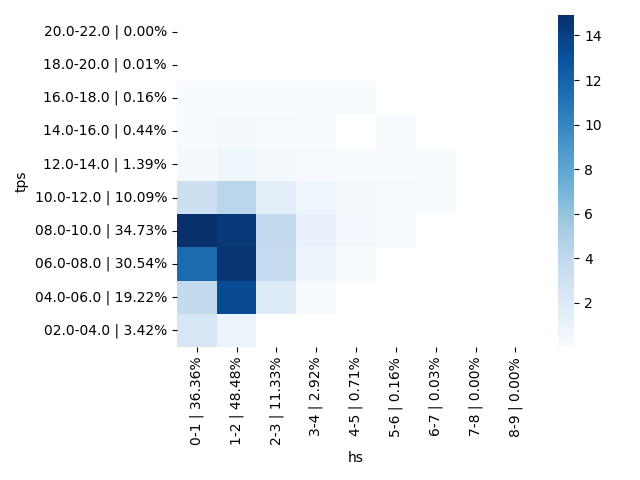

In [12]:
r = plots.scatter_diagram(
    df,
    var1="tps",
    step_var1=2,
    var2="hs",
    step_var2=1,
    output_file="Hs_Tp_scatter.png"
)

Image(filename="Hs_Tp_scatter.png")

### Monthly non exceedance table

In [13]:
tables.table_monthly_non_exceedance(
    df,
    var="hs",
    step_var=0.5,
    output_file="hs_table_monthly_non_exceedance.csv"
)

time,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,Year
hs-level,,,,,,,,,,,,,
<0.5,2.16,2.05,2.83,0.91,1.46,1.18,1.02,1.60,0.98,1.98,2.44,2.38,1.75
<1.0,27.34,26.42,27.46,26.40,34.68,49.57,56.08,59.05,34.55,33.83,29.64,30.05,36.26
<1.5,56.18,56.88,56.47,60.44,75.71,87.40,90.36,88.84,69.24,65.99,59.78,58.86,68.85
<2.0,76.49,77.78,76.55,80.49,91.10,96.80,97.47,95.77,85.18,82.96,80.09,76.65,84.78
<2.5,86.92,89.31,88.01,91.15,96.30,99.04,99.11,97.83,93.00,90.69,89.93,87.15,92.37
<3.0,93.11,94.79,94.12,96.36,98.26,99.68,99.68,98.92,96.49,94.51,94.83,93.21,96.16
<3.5,96.74,97.52,97.19,98.57,99.42,100.00,99.85,99.60,98.39,96.93,97.06,96.51,98.15
<4.0,98.18,98.66,98.77,99.45,99.82,100.00,99.94,99.82,99.22,98.35,98.55,98.29,99.09
<4.5,98.87,99.36,99.40,99.80,99.96,100.00,99.96,99.87,99.64,99.29,99.36,99.27,99.57


### Monthly statistics plot

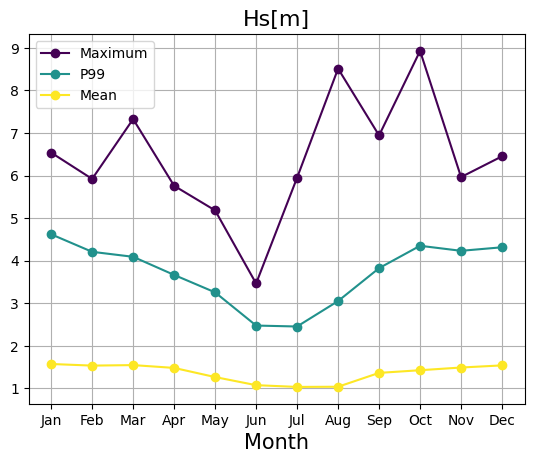

In [14]:
p = plots.plot_monthly_stats(
    df,
    var="hs",
    show=["Maximum", "P99", "Mean"],
    title="Hs[m]",
    output_file="hs_monthly_stats.png",
)

### Monthly Statistics with shades

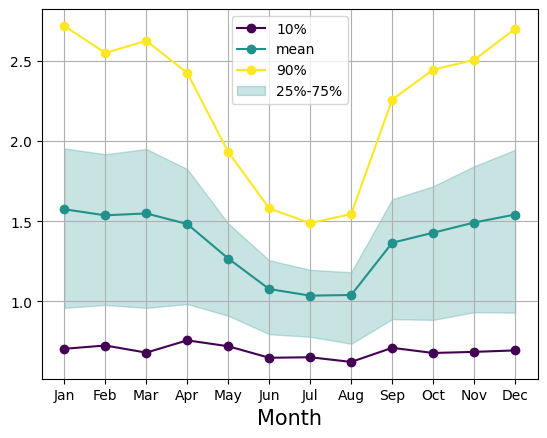

In [15]:
p = plots.plot_monthly_stats(
   df,
   var="hs",
   show=["10%", "mean", "90%"],
   fill_between=["25%", "75%"],
   fill_color_like="mean",
   output_file="")


### Hs Daily Statistics with shaded band

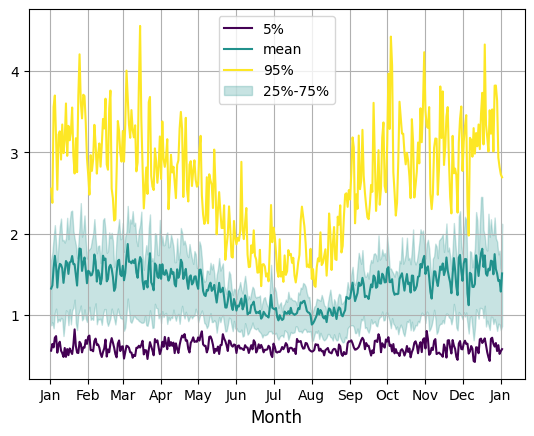

In [16]:
p = plots.plot_daily_stats(
   df,
   var="hs",
   show=["5%", "mean", "95%"],
   fill_between=["25%", "75%"],
   fill_color_like="mean"
)

### Directional Non-Exceedance Table

In [17]:
tables.table_directional_non_exceedance(
    df,
    var="hs",
    step_var=0.5,
    var_dir="dpm",
    output_file="table_directional_non_exceedance.csv"
)

direction_sector,0°,30°,60°,90°,120°,150°,180°,210°,240°,270°,300°,330°,Omni
hs-level,,,,,,,,,,,,,
<0.5,0.01,0.00,0.01,0.38,1.06,0.19,0.08,0.01,0.00,0.00,0.00,0.01,1.75
<1.0,0.34,0.19,0.22,5.98,15.69,6.92,5.34,0.53,0.12,0.20,0.35,0.49,36.36
<1.5,0.87,0.50,0.63,12.01,23.35,13.53,13.57,1.01,0.24,0.57,1.23,1.45,68.96
<2.0,1.14,0.62,0.89,15.01,26.29,17.01,17.26,1.17,0.29,0.94,2.07,2.15,84.84
<2.5,1.24,0.68,1.03,16.57,27.55,18.96,18.71,1.21,0.31,1.16,2.51,2.47,92.40
<3.0,1.28,0.70,1.11,17.51,28.18,20.08,19.23,1.21,0.32,1.28,2.70,2.58,96.17
<3.5,1.29,0.70,1.17,18.08,28.53,20.69,19.47,1.22,0.32,1.32,2.74,2.62,98.15
<4.0,1.30,0.70,1.19,18.39,28.71,21.01,19.54,1.22,0.33,1.33,2.75,2.63,99.09
<4.5,1.30,0.70,1.20,18.57,28.78,21.19,19.57,1.22,0.33,1.33,2.75,2.63,99.57


### Directional statistics plot

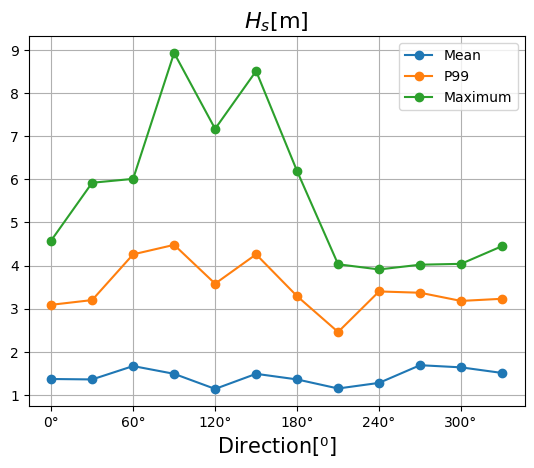

In [18]:
p = plots.plot_directional_stats(
    df,
    var="hs",
    step_var=0.5,
    var_dir="dpm",
    title="$H_s$[m]",
    output_file="directional_stats.png",
)

### Prob. of Non-Exceedance (fitted)

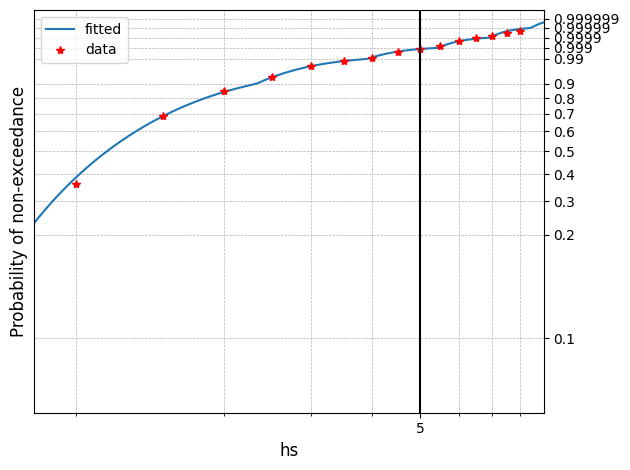

In [19]:
plots.plot_prob_non_exceedance_fitted_3p_weibull(
    df,
    var="hs",
    output_file="prob_non_exceedance_fitted_3p_weibull.png",
)

### Joint Distribution Hs-Tp Plot

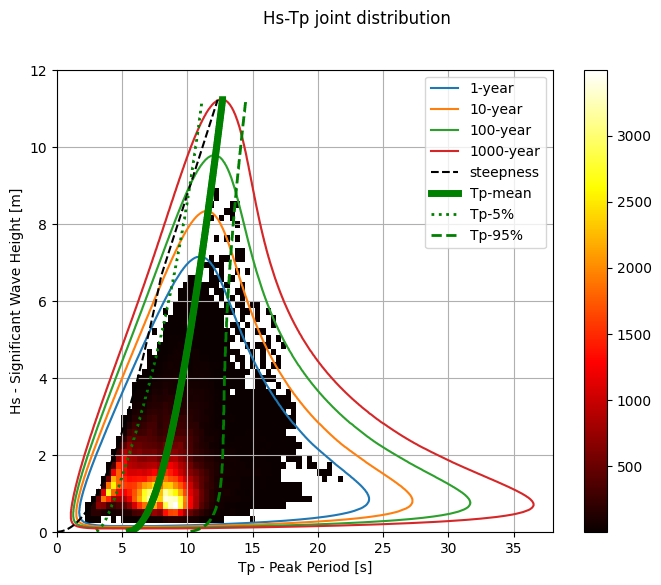

In [20]:
p = plots.plot_joint_distribution_Hs_Tp(
    df,
    var_hs="hs",
    var_tp="tps",
    periods=[1, 10, 100, 1000],
    title="Hs-Tp joint distribution",
    output_file="Hs.Tp.joint.distribution.png",
    density_plot=True,
)

### Monthly Joint Distribution Hs-Tp Parameter Table

In [21]:
tables.table_monthly_joint_distribution_Hs_Tp_param(
    df,
    var_hs="hs",
    var_tp="tps",
    periods=[1, 10, 100, 10000],
    output_file="monthly_Hs_Tp_joint_param.csv",
)

,a1,a2,a3,b1,b2,b3
Month,,,,,,
Jan,1.631,0.352,0.36,0.005,0.258,0.648
Feb,1.732,0.280,0.36,0.005,0.198,0.563
Mar,1.714,0.307,0.36,0.005,0.200,0.552
Apr,1.781,0.250,0.36,0.005,0.114,0.541
May,1.754,0.261,0.36,0.005,0.091,0.568
Jun,1.884,0.121,0.36,0.005,0.075,0.583
Jul,1.758,0.243,0.36,0.005,0.054,0.280
Aug,1.692,0.393,0.36,0.005,0.081,0.086
Sept,1.813,0.336,0.36,0.005,0.113,0.176


### Directional Joint Distribution Hs-Tp Parameter Table

In [22]:
tables.table_directional_joint_distribution_Hs_Tp_param(
    df,
    var_hs="hs",
    var_tp="tps",
    var_dir="dpm",
    periods=[1, 10, 100],
    output_file="dir_Hs_Tp_joint_param.csv",
)

,a1,a2,a3,b1,b2,b3
Direction,,,,,,
0°,0.436,0.942,0.36,0.005,0.032,2.132
30°,0.490,0.913,0.36,0.005,0.028,1.535
60°,0.942,0.687,0.36,0.005,0.046,0.647
90°,2.058,0.113,0.36,0.005,0.077,0.389
120°,1.940,0.232,0.36,0.005,0.056,0.187
150°,1.578,0.452,0.36,0.005,0.027,0.063
180°,1.347,0.466,0.36,0.005,0.078,0.833
210°,0.753,0.752,0.36,0.005,0.114,1.847
240°,0.064,1.239,0.36,0.005,0.180,5.817


### Number Of Hours Per Year Below A Threshold Plot

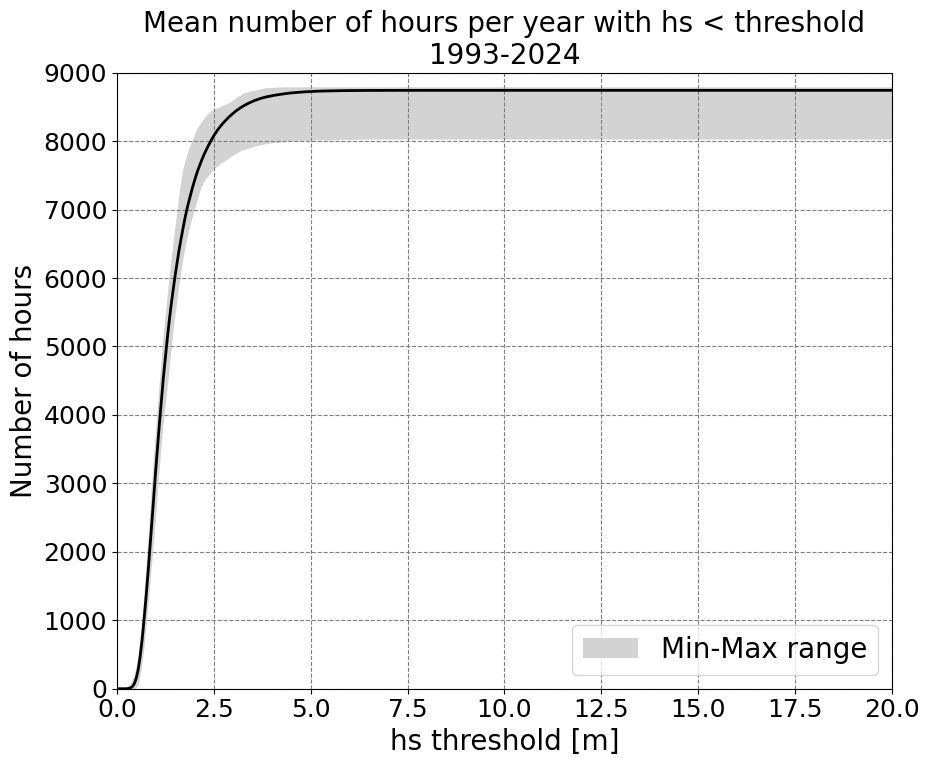

In [23]:
plots.plot_nb_hours_below_threshold(
    df,
    var="hs",
    thr_arr=(np.arange(0.05, 20.05, 0.05)).tolist(),
    output_file="number_hours_per_year.png"
)

### Number of hours per year below a threshold Table

In [24]:
tables.table_nb_hours_below_threshold(
    df,
    var="hs",
    threshold=[1,2,3,4,5,6,7,8,9,10],
    output_file="number_hours_per_year.csv"
)

,hs,Minimum,Mean,Maximum
0,<1,2661,3179,3673
1,<2,7044,7418,8065
2,<3,7812,8408,8593
3,<4,7987,8663,8775
4,<5,8026,8725,8784
5,<6,8034,8740,8784
6,<7,8041,8742,8784
7,<8,8041,8742,8784
8,<9,8041,8743,8784
9,<10,8041,8743,8784


### All-Year Round Weather Window For Hs Under A Threshold Table

In [25]:
tables.table_weather_window_thresholds(
    df,
    var="hs",
    threshold=[0.5, 1, 2],
    op_duration=[6, 12, 24, 48],
    output_file="weather_window_thresholds.csv",
)

,Operation duration [h],hs<0.5m,hs<1m,hs<2m
0,6,41.05,2.19,0.43
1,12,86.99,3.07,0.74
2,24,279.10,6.07,1.41
3,48,3769.26,19.62,3.03


### Directional Return Periods Plot (GUM)

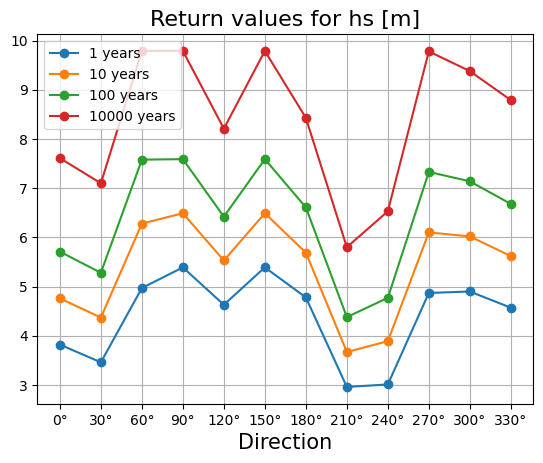

In [26]:
p = plots.plot_directional_return_periods(
    df,
    var="hs",
    var_dir="dpm",
    periods=[1, 10, 100, 10000],
    distribution="GUM",
    units="m",
    output_file="dir_extremes_GUM.png",
)


### Monthly Joint Distribution Hs-Tp Return Values Table

In [27]:
tables.table_monthly_joint_distribution_Hs_Tp_return_values(
    df,
    var_hs="hs",
    var_tp="tps",
    periods=[1, 10, 100, 10000],
    output_file="monthly_Hs_Tp_joint_return_values.csv",
)

,Month,Annual prob.[%],H_s [1 years],T_p [1 years],H_s [10 years],T_p [10 years],H_s [100 years],T_p [100 years],H_s [10000 years],T_p [10000 years]
0,Jan,8.33,6.12,10.05,7.30,10.51,8.73,11.03,11.45,11.93
1,Feb,8.33,5.46,9.49,6.45,9.83,7.63,10.17,9.86,10.77
2,Mar,8.33,5.65,9.91,6.67,10.29,7.86,10.69,10.11,11.37
3,Apr,8.33,4.83,9.25,5.63,9.49,6.57,9.75,8.32,10.19
4,May,8.33,4.33,9.05,5.17,9.35,6.21,9.67,8.21,10.21
5,Jun,8.33,3.20,7.93,3.76,8.03,4.43,8.13,5.70,8.31
6,Jul,8.33,3.57,8.51,4.40,8.77,5.45,9.07,7.61,9.61
7,Aug,8.33,5.19,10.81,6.99,11.73,9.46,12.89,15.11,15.25
8,Sept,8.33,5.32,11.11,6.45,11.67,7.84,12.29,10.56,13.37
9,Oct,8.33,6.23,9.95,7.65,10.31,9.42,10.73,12.94,11.45


### Hs-Tp Return Values Table

In [28]:
tables.table_Hs_Tpl_Tph_return_values(
    df,
    var_hs="hs",
    var_tp="tps",
    periods=[1, 10, 100, 10000],
    output_file="hs_tpl_tph_return_values.csv",
)

,HS [1 years],TpL [1 years],TpH [1 years],HS [10 years],TpL [10 years],TpH [10 years],HS [100 years],TpL [100 years],TpH [100 years],HS [10000 years],TpL [10000 years],TpH [10000 years]
0,7.1,10.5,11.4,8.3,11.1,11.8,9.8,11.8,12.2,12.7,12.9,13.3
1,6.1,8.3,13.2,7.3,9.0,13.4,8.8,9.8,13.8,11.7,11.1,14.7
2,5.1,6.8,14.4,6.3,7.7,14.5,7.8,8.6,14.6,10.7,10.0,15.3
3,4.1,5.5,15.9,5.3,6.4,15.7,6.8,7.5,15.5,9.7,9.1,15.8
4,3.1,4.2,17.9,4.3,5.2,17.2,5.8,6.4,16.6,8.7,8.2,16.4
5,2.1,3.0,20.7,3.3,4.0,19.3,4.8,5.2,18.2,7.7,7.3,17.2
6,1.1,2.0,24.0,2.3,2.9,22.3,3.8,4.1,20.3,6.7,6.3,18.2
7,0.1,3.9,7.7,1.3,2.0,26.5,2.8,3.1,23.3,5.7,5.3,19.7
8,0.1,3.9,7.7,0.3,1.6,21.7,1.8,2.1,27.7,4.7,4.3,21.7
9,0.1,3.9,7.7,0.1,5.2,5.6,0.8,1.4,32.3,3.7,3.3,24.8


### TP for Given HS Plot

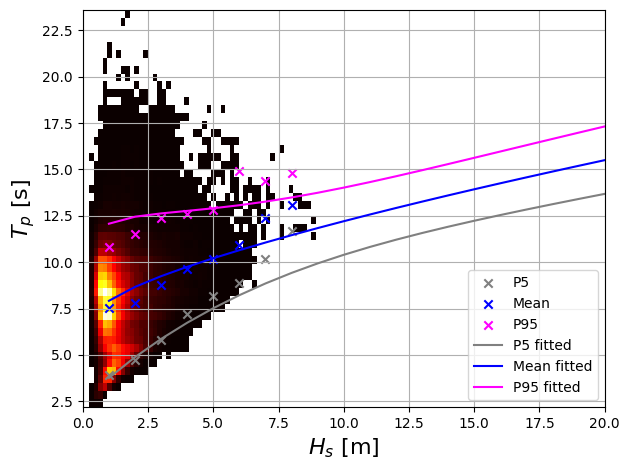

In [29]:
p = plots.plot_tp_for_given_hs(
    df,
    var_hs="hs",
    var_tp="tps",
    output_file="tp_for_given_hs.png",
)

### TP for Given HS Table

In [30]:
tables.table_tp_for_given_hs(
    df,
    var_hs="hs",
    var_tp="tps",
    max_hs=20,
    output_file="tp_for_given_hs.csv",
)

,hs_bin,Hs[m],Tp(P5-obs) [s],Tp(Mean-obs) [s],Tp(P95-obs) [s],Tp(P5-model) [s],Tp(Mean-model) [s],Tp(P95-model) [s]
0,"[0.5, 1.5)",1.0,3.90,7.542816,10.800,3.746681,7.921942,12.097204
1,"[1.5, 2.5)",2.0,4.70,7.787010,11.600,4.852982,8.668194,12.483406
2,"[2.5, 3.5)",3.0,5.80,8.755138,12.400,5.823174,9.244329,12.665484
3,"[3.5, 4.5)",4.0,7.20,9.629975,12.700,6.689391,9.745591,12.801791
4,"[4.5, 5.5)",5.0,8.10,10.171178,12.765,7.467289,10.204138,12.940988
5,"[5.5, 6.5)",6.0,8.80,10.933333,14.875,8.167392,10.634315,13.101237
6,"[6.5, 7.5)",7.0,10.07,12.433333,14.600,8.798048,11.043609,13.289171
7,"[7.5, 8.5)",8.0,11.62,13.183333,15.080,9.366679,11.436419,13.506159
8,"[8.5, 9.5)",9.0,NaN,NaN,NaN,9.880408,11.815588,13.750768
9,"[9.5, 10.5)",10.0,NaN,NaN,NaN,10.346303,12.183116,14.019929


### Tp for RV Hs Table

In [31]:
tables.table_tp_for_rv_hs(
    df,
    var_hs="hs",
    var_tp="tps",
    periods=[1, 10, 100, 10000],
    output_file="tp_for_rv_hs.csv",
)

,Return period [years],Hs[m],Tp(P5-model) [s],Tp(Mean-model) [s],Tp(P95-model) [s]
0,1,7.14,8.866930,11.105391,13.343852
1,10,8.32,9.525482,11.565546,13.605609
2,100,9.77,10.235866,12.106680,13.977494
3,10000,12.65,11.401320,13.119890,14.838459
